<h1> Kiavash jamshidi 810197486 </h1>

In [1]:
import pandas as pd
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from hazm import *
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
stopWordsDict = {x:None for x in stopwords_list()}
infoGainEveryFeature = {}
df = pd.read_csv('data/data/vehicles.csv')
del df['created_at']
tagger = POSTagger(model='resources/postagger.model')
basedForm = Lemmatizer()
scaler = StandardScaler()
vectorizer = CountVectorizer()
linearRegressor = LinearRegression()
entropy = 0
trainDf = None
testDf = None

In [3]:
def putLabelOnStrings(col):
    id = 0
    labelDict = {}
    for row in range(len(df[col])):
        if pd.isna(df[col][row]): continue
        if df[col][row] not in labelDict:
            labelDict[df[col][row]] = id
            id += 1
        df.at[row,col] = labelDict[df[col][row]]
    invVocab = {value:key for key,value in labelDict.items()}
    return invVocab

In [4]:
brandDct = putLabelOnStrings('brand')
catDct = putLabelOnStrings('category')

In [5]:
def replaceNanWithProb():
    for col in df.columns:
        if not (col == 'brand' or col == 'mileage' or col == 'year') : continue
        titleCount = {}
        total = 0
        for row in range(len(df[col])):
            if pd.isna(df[col][row]): continue
            if df[col][row] not in titleCount: titleCount[df[col][row]] = 1
            else: titleCount[df[col][row]] += 1
            total += 1

        for title in titleCount:
            titleCount[title] /= total

        titleCount = sorted(titleCount.items(), key=lambda x: x[1], reverse=True)

        for row in range(len(df[col])):
            if not pd.isna(df[col][row]): continue
            num = random.random()
            whichTitle = None
            tmp = 0
            for t in titleCount:
                if num < tmp + t[1]:
                    whichTitle = t[0]
                    break
                tmp += t[1]

            df.at[row,col] = whichTitle

In [6]:
replaceNanWithProb()

In [7]:
def I(dct,total,result,num):
    for i in dct.values():
        result -= math.log(i/total,num) * (i/total)
    return result

def calculateEntropy():
    tmp = {}
    result = 0
    totalNums = len(trainDf['price'])
    for cell in trainDf['price']:
        if cell not in tmp:
            tmp[cell] = 1
        else:
            tmp[cell] += 1

    result = I(tmp,totalNums,result,len(tmp))
    
    return result,len(tmp)

def calculateColGain(col,num):
    brands = {}
    result = entropy
    total = len(trainDf)

    for row in trainDf[col]:
        if row in brands: continue
        brands[row] = {}
        eachBrandDf = trainDf[trainDf[col] == row]
        for secRow in eachBrandDf['price']:
            if secRow in brands[row]:
                brands[row][secRow] += 1
            else:
                brands[row][secRow] = 1

        brandTotal = sum(brands[row].values())
        tmpResult = 0
        result -= (brandTotal / total) * I(brands[row],brandTotal,tmpResult,num)

    return result

<h2> Q3 </h2> <br/>
به این صورت عمل میکنیم که با <br/>
Countvectorizer <br/>
تعداد تکرار کلمه ها در کل را پیدا می کنیم. سپس ۱۰ تای پرتکرارترین را به عنوان یک ستون جدید اضافه میکنیم که در هر سلول قرار است تعداد تکرار آن کلمه در ستون متناظر را بنویسیم

In [8]:
def thisWordIsTrash(word):
    return word[0] in stopWordsDict or basedForm.lemmatize(word[0]) in stopWordsDict \
        or word[1] == 'PUNC' or word[1] == 'P' or word[1] == 'Pe' or word[1] == 'NUMe' \
        or word[1] == 'ADV' or word[1] == 'CONJ' or word[1] == 'DET' \
        or word[1] == 'Pe' or word[1] == 'PRO' or word[1] == 'POSTP' \
        or word[1] == 'NUM' or word[1] == 'AJ' or word[1] == 'V' or word[1] == 'INT'

def getBaseformOfWord(word):
    baseFormOfWord = basedForm.lemmatize(word[0]).split('#')[0]
    return baseFormOfWord


lstForCount = []
for row in range(len(df['title'])):
    if row == 80000: break            
    if df['price'][row] == -1: continue
    wholeStr = df['title'][row] + ' ' + df['description'][row]
    words = tagger.tag(word_tokenize(wholeStr))
    analyzeWord = ""
    for word in words:
        if thisWordIsTrash(word): continue
        baseFormOfWord = getBaseformOfWord(word)
        analyzeWord += baseFormOfWord + ' '
    lstForCount.append(analyzeWord)

In [9]:
def getVocab(inputLst):
    vocab = vectorizer.fit_transform(inputLst)
    countingVocab = vocab.toarray().sum(axis = 0)

    indx = {}
    for i in range(len(countingVocab)):
        indx[countingVocab[i]] = i
    sortedIndexes = sorted(indx.items(),reverse=True)
    invVocab = {value:key for key,value in vectorizer.vocabulary_.items()}
    sortedVocabWords = []
    for i in sortedIndexes:
        if i[1] in invVocab:
            sortedVocabWords.append(invVocab[i[1]])
    return sortedVocabWords[:10]

sortedVocabWords = getVocab(lstForCount)
print("Most repeated words are",", ".join(sortedVocabWords))

Most repeated words are بیمه, رنگ, مدل, تخفیف, پراید, لاستیک, سال, ماشین, پژو, فن


In [10]:
for word in sortedVocabWords[:7]:
    wordRepeatLst = []
    for desc,titl in zip(df['description'],df['title']):
        num = desc.count(word) + titl.count(word)
        wordRepeatLst.append(num)
    df[word] = wordRepeatLst
df

,brand,category,description,image_count,mileage,price,title,year,بیمه,رنگ,مدل,تخفیف,پراید,لاستیک,سال
0,12,0,سریال 43j$NUMبدون شکستگی سه حلقه لاستیک نو یک ...,4,152000.0,-1,لودر کاتر پیلار 950,1393,0,0,0,0,0,1,1
1,0,1,دوگانه ال پی جی بیمه با تخفیف دارد \nتودوزی نو...,3,180000.0,-1,پاترول شش سیلندر چهار درب,1366,1,0,0,1,1,1,0
2,1,1,پژو 2000فنی تازه تعمیر بدنه بدون خطو خش تخیف ب...,0,290000.0,8500000,پژو مدل 81 مشکی,1381,2,0,1,0,0,1,2
3,2,1,سلام.\nماشین کاملا سالم همه چی فابریک متور زد ...,3,175000.0,19500000,پاترول 2در,1372,0,0,0,0,0,1,1
4,3,1,سمند ال ایکس بدون رنگ تمامی سرویس ها انجام شده...,4,80000.0,23900000,سمند دوگانه کارخانه,1391,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130438,5,0,بادسان فوق بیرنگ سفید رنگ بیمه تابرج 3.96 تخفی...,2,1234.0,48000000,بادسان 8b14 مدل83,1394,1,2,1,1,0,1,1
130439,19,0,باسلام .تراکتورازصفری دست خودم بوده.سالم.ودارا...,4,212000.0,-1,تراکتورگلدونی ۲۳۸ایتالیا,1394,0,0,1,0,0,0,4
130440,3,1,ماشینم تصادفیه با خریدار توافق میکنم سر قیمتش,3,20000.0,-1,خودرو سمند تصادفی مدل92,1392,0,0,1,0,0,0,0
130441,5,1,سند۲ برگ،بیمه تا برج$NUMتخفیفات بیمه 15 سال،مع...,4,123000.0,6900000,پراید 79 بسیار سالم,1379,2,1,0,1,1,1,5


<h2> Q4 </h2> 
<br/>
چند تا راه حل وجود دارد. یکی آن که در داده های عددی میتوانیم در جاهای خالی میانگین اعداد را بگذاریم. دیگری آن که اطلاعات سطر بعد کپی کنیم. دیگری آنکه اطلاعات سطر قبل را کپی می کنیم. راه حل من اینگونه بوده که هم در داده های دسته ای هم در داده های عددی درست کار میکند. به این صورت که اول لیبل روی داده های دسته ای میگذاریم. سپس بدست میاریم که احتمال آنها (تعداد تکرار در کل) چقدر است. سپس یک عدد رندوم تولید میکنیم و طبق آن بدست می آوریم که کدام لیبل یا عدد باید در این جای خالی بماند


In [11]:
ybrand = pd.get_dummies(df['brand'])
ycategory = pd.get_dummies(df['category'])

for col in ybrand.columns:
    df[brandDct[col]] = ybrand[col]
for col in ycategory.columns:   
    df[catDct[col]] = ycategory[col]

<h2> Q2 </h2> <br/>
برای داده های دسته ای مانند دیکشنری عمل میکنیم. به همه آنها یک عدد خاص اختصاص می دهیم و با آن جایگذاری میکنیم. سپس بعد از آن مقادیر جاخالی زا پر میکنیم. و بعد از آن روی همین ستون های دسته ای <br/>
One Hot<br/>
میزنیم

In [12]:
for row in range(len(df['year'])):
    if df['year'][row] == '<1366':
        df.at[row,'year'] = -1366

trainDf = df[df['price'] != -1]
testDf =  df[df['price'] == -1]

del trainDf['description']
del trainDf['title']
del trainDf['category']
del trainDf['brand']

entropy,num = calculateEntropy()
print("Entropy is",entropy)
print()

colGains = {}
for col in trainDf.columns:
    if col == 'price': continue
    result = calculateColGain(col,num)
    colGains[col] = result

xplt = []
yplt = []
for i in colGains:
    xplt.append(i)
    yplt.append(colGains[i])
    print("For {} information gain is {}".format(i,colGains[i]))

Entropy is 0.7480830658595581

For image_count information gain is 0.0059197752396213206
For mileage information gain is 0.1378551599993638
For year information gain is 0.07855441925201502
For بیمه information gain is 0.009042812934907378
For رنگ information gain is 0.0060551784078382645
For مدل information gain is 0.0035070353984365467
For تخفیف information gain is 0.0094098049321794
For پراید information gain is 0.02468960982876348
For لاستیک information gain is 0.002566893892978477
For سال information gain is 0.009532995935181442
For سایر information gain is 0.007786453412586519
For پژو ۴۰۵::Peugeot 405 information gain is 0.0035640132796872503
For نیسان::Nissan information gain is 0.0015433418636409436
For سمند::Samand information gain is 0.004658227700183322
For ام‌وی‌ام::MVM information gain is 0.0021519119844878275
For پراید صندوق‌دار::Pride information gain is 0.01943538508568282
For پراید هاچ‌بک::Pride information gain is 0.004046842500811318
For پژو پارس::Peugeot Pars informa

<h2> Q1 </h2> <br/>
این نمودار به ما نشان می دهد که بیشترین اطلاعات قیمت را از کدام ستون می توان استخراج کرد. در کل ما ستون های بیشترین کلمه های تکرار شده را اضافه کردیم.   <br/>
 با روش <br/>
One Hot encoding <br/> 
نیز ستون های برند و کتگوری را عوض می کنیم و سپس این ۲ ستون را پاک می کنیم. سپس ستون های برند و کتگوری را حذف میکنیم. همینطور ستون های توضیحات و عنوان را نیز حذف می کنیم. 

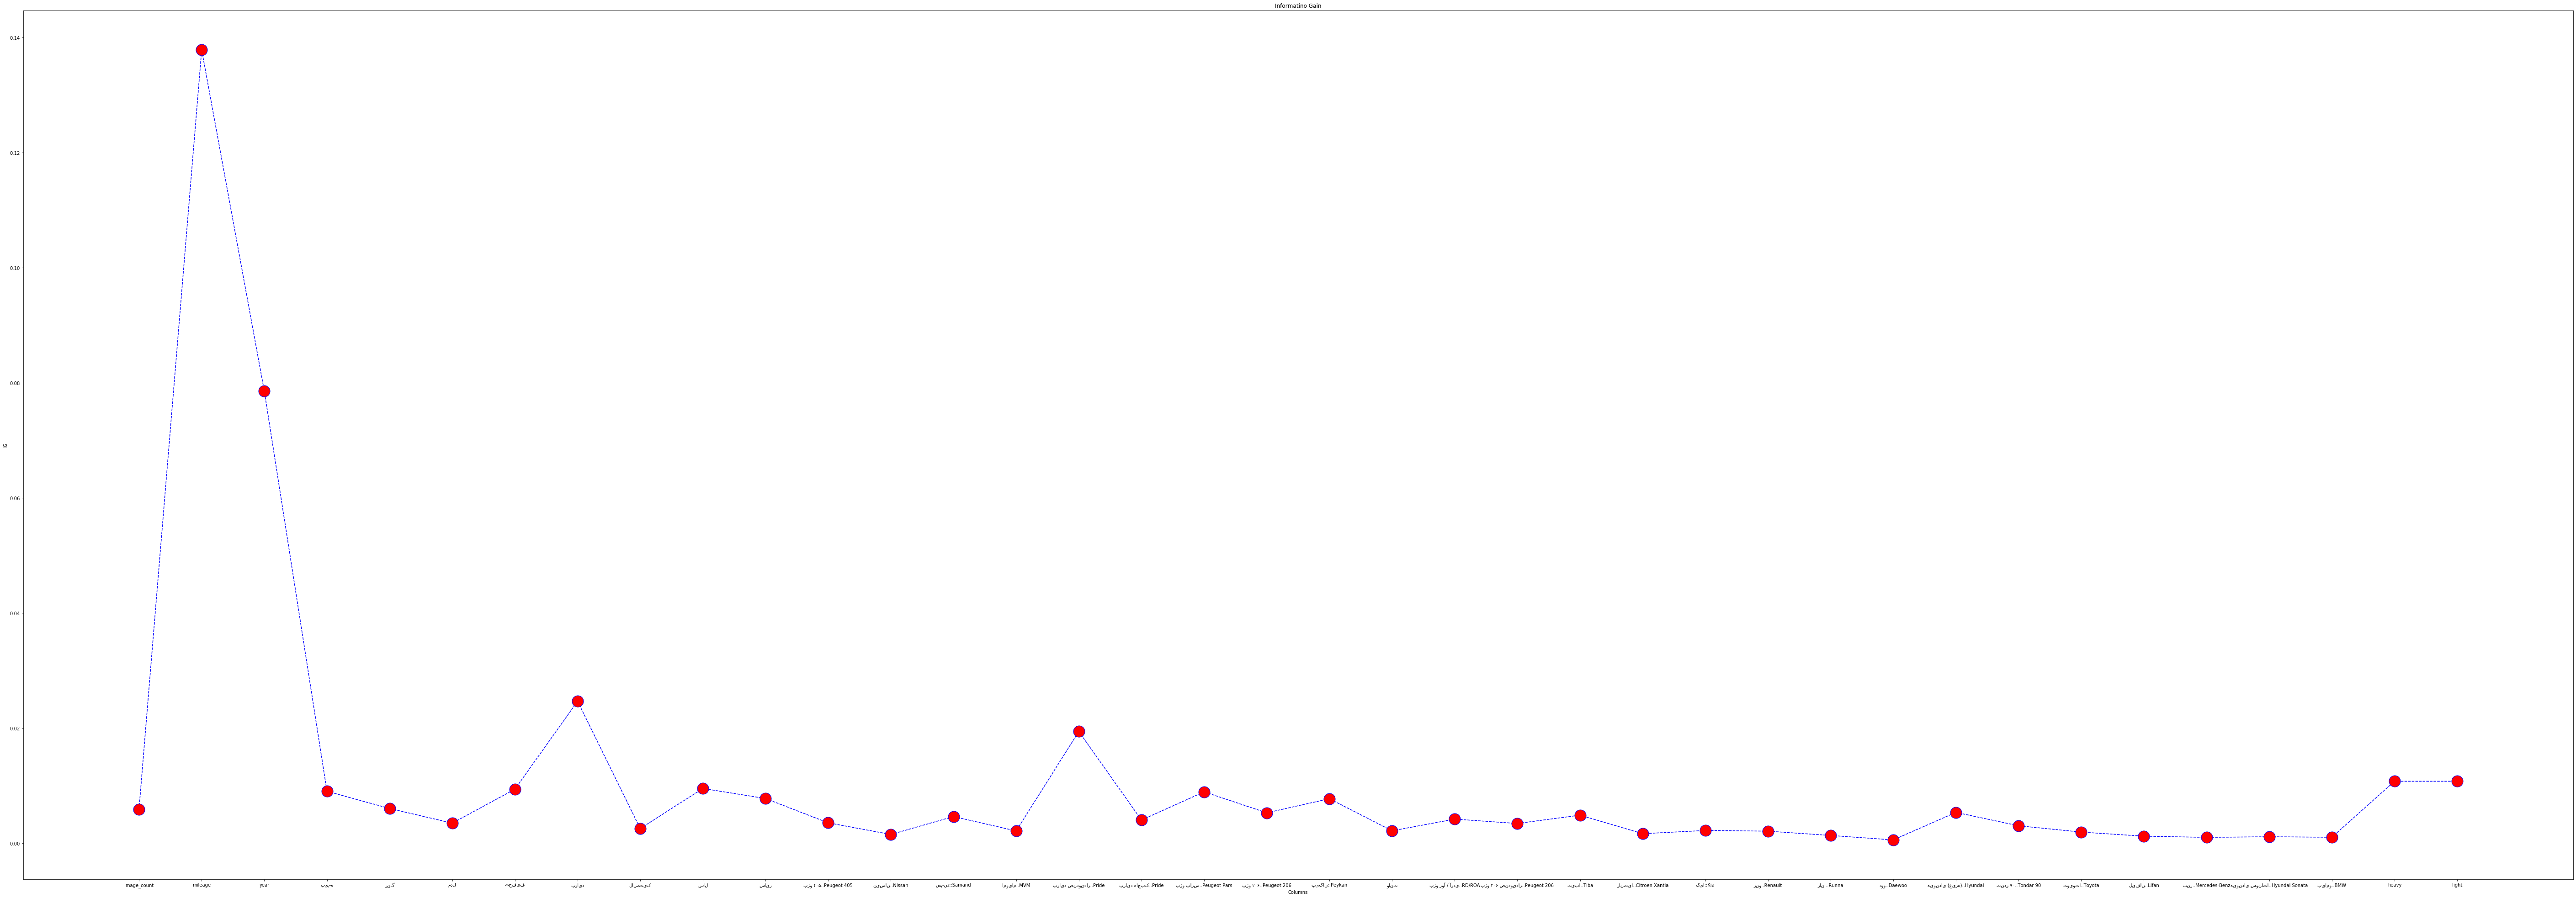

In [13]:
plt.figure(figsize = (100,35))
plt.title('Informatino Gain')
plt.xlabel('Columns')
plt.ylabel('IG')
plt.plot(xplt,yplt,color ='blue', linestyle ='dashed', marker ='o',
        markerfacecolor ='red', markersize = 25)
plt.show()

<h2> KNN </h2>

<h2> Q5 , Q6 </h2> <br/>
در بیشتر الگوریتم ها داده ها را به نسبت 0.2 و 0.8 تقسیم کرده ام. (در بعضی حاها 0.25 و 0.75 ). اگر از داده کمی استفاده کنیم باعث می شود که <br/> underfitting <br/> رخ دهد که باعث می شود خوب جنرالایز نشود. <br/> و اگر هم زیاد استفاده کنیم خیلی سعی می کند که شبیه داده باشد که باعث می شود <br/> overfitting <br/> رخ دهد
<br/>
در کل هر چه ارتفاع دخت بیشتر شود پیچیده تر می شود چون باید اطلاعات بیشتری از داده باید استخراج کند و خیلی خیلی شبیه دیتای داده شده می شود که مناسب نیست. <br/>


In [14]:
print("Scaling...")
scaler.fit(trainDf.drop('price', axis = 1))
scaled_features = scaler.transform(trainDf.drop('price', axis = 1))

print("Training...")
X_train, X_test, y_train, y_test = train_test_split(scaled_features, trainDf['price'], test_size = 0.25)
K = 34
knn = KNeighborsClassifier(n_neighbors = K)
  
knn.fit(X_train, y_train)
print("Testing...")
y_pred = knn.predict(X_test)
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

Scaling...
Training...
Testing...


,Actual,Predicted
118615,12500000,10500000
124324,21800000,18000000
51553,15800000,17500000
92744,32500000,28000000
86465,19000000,19000000
...,...,...
15384,16000000,13500000
38743,25700000,21500000
56994,22000000,20000000
87663,25500000,26000000


In [15]:
print('With K = {}'.format(K))

print('MSE for KNN:', round(metrics.mean_squared_error(y_test, y_pred)))
print('RMSE for KNN:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

With K = 34
MSE for KNN: 645796331488458.0
RMSE for KNN: 25412523.0


<h2> Decision Tree </h2>

In [16]:
X = trainDf.drop('price', axis=1)
y = trainDf['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

rmseLst = []
mseLst = []
for i in range(1,25):
    regressor = DecisionTreeRegressor(max_depth = i)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmseLst.append(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    mseLst.append(round(metrics.mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'RMSE')

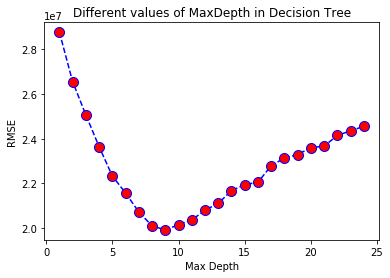

In [17]:
plt.plot(range(1, 25), rmseLst, color ='blue', linestyle ='dashed', marker ='o',
        markerfacecolor ='red', markersize = 10)
plt.title('Different values of MaxDepth in Decision Tree')
plt.xlabel('Max Depth')
plt.ylabel('RMSE')

Text(0, 0.5, 'MSE')

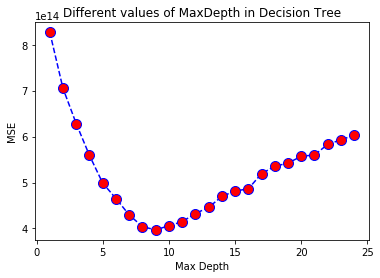

In [18]:
plt.plot(range(1, 25), mseLst, color ='blue', linestyle ='dashed', marker ='o',
        markerfacecolor ='red', markersize = 10)
plt.title('Different values of MaxDepth in Decision Tree')
plt.xlabel('Max Depth')
plt.ylabel('MSE')

In [19]:
regressor = DecisionTreeRegressor(max_depth = 11)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print('MSE for decision tree:', round(metrics.mean_squared_error(y_test, y_pred)))
print('RMSE for decision tree:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

MSE for decision tree: 417538046070820.0
RMSE for decision tree: 20433748.0


<h2> Linear regression </h2>

In [20]:
X = trainDf.drop('price', axis=1)
y = trainDf['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
linearRegressor.fit(X_train, y_train)
y_pred = linearRegressor.predict(X_test)
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
53158,19700000,1.957954e+07
40220,24500000,2.239888e+07
11921,11200000,2.532723e+07
21386,26000000,2.107688e+07
10936,18500000,2.509983e+07
...,...,...
65823,14500000,1.681278e+07
117400,7800000,1.946836e+06
128531,12000000,7.828723e+06
83860,7000000,9.314050e+06


In [21]:
print('MSE:', round(metrics.mean_squared_error(y_test, y_pred)))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

MSE: 480159539859439.0
RMSE: 21912543.0


<h2> Forest </h2>

<h2> Q7 </h2> <br/>
برای فقط یک درخت واریانس کم است ولی بایاس زیاد است. اما برای جنگل به این صورت است که بایاس آن بیشتر از درخت است و همینطور واریانس کمتر از واریانس تک درخت

In [22]:
X = trainDf.drop('price', axis=1)
y = trainDf['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regressor = RandomForestRegressor(n_estimators=75, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
53158,19700000,1.913200e+07
40220,24500000,1.828533e+07
11921,11200000,1.765211e+07
21386,26000000,2.645200e+07
10936,18500000,3.208400e+07
...,...,...
11446,19500000,1.777320e+07
16557,5500000,6.634287e+06
67757,5600000,5.456000e+06
83569,105000000,6.864133e+07


In [23]:
print('MSE for forest:', round(metrics.mean_squared_error(y_test, y_pred)))
print('RMSE for forest:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))

MSE for forest: 351849554634435.0
RMSE for forest: 18757653.0
